In [2]:
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
labels_dict = {
    '0' : 'aeroplane',
    '1' : 'bicycle',
    '2' : 'bird',
    '3' : 'boat',
    '4' : 'bottle',
    '5' : 'bus',
    '6' : 'car',
    '7' : 'cat',
    '8' : 'chair',
    '9' : 'cow',
    '10' : 'diningtable',
    '11' : 'dog',
    '12' : 'horse',
    '13' : 'motorbike',
    '14' : 'person',
    '15' : 'pottedplant',
    '16' : 'sheep',
    '17' : 'sofa',
    '18' : 'train',
    '19' : 'tvmonitor'
}

In [7]:
image_name = 'demo'
img = cv2.imread(f"../simple-faster-rcnn-pytorch\misc\{image_name}.jpg")
img = t.from_numpy(img)[None]
img = img.permute(0,3,1,2)
img.shape
# convert rgb to bgr
img = img[:,(2, 1, 0), :, :]

In [4]:
os.makedirs('overlayed', exist_ok=True)

In [5]:
def overlay_masks(masks_dir  , image_path):
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = os.listdir(masks_dir)
    image_name = image_path.split('/')[-1].split('.')[0]
    os.makedirs(f'overlayed/{image_name}', exist_ok=True)
    for mask_name in masks:
        mask_path = os.path.join(masks_dir, mask_name)
        mask = cv2.imread(mask_path)
        # mask is a 3 channel image, we only need one channel which is binary
        mask = mask[:,:,0]
        mask = mask/255

        # overlay mask on image
        overlay = image.copy()
        overlay[:,:,0] = mask*image[:,:,0]
        overlay[:,:,1] = mask*image[:,:,1]
        overlay[:,:,2] = mask*image[:,:,2]

        # save overlayed image
        cv2.imwrite(f'overlayed/{image_name}/{mask_name}', overlay)

In [6]:
overlay_masks('../simple-faster-rcnn-pytorch\Masks2' , '../simple-faster-rcnn-pytorch\misc\demo.jpg')

KeyboardInterrupt: 

In [8]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Setting up a new session...
Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
                  

Exception in user code:
------------------------------------------------------------


[array([ 6, 11, 12, 14, 14])]
[array([[ 95.61549  ,   4.2916183, 199.87706  , 135.44626  ],
       [204.43149  , 134.16513  , 356.93277  , 199.60114  ],
       [ 63.815353 , 211.67177  , 344.87817  , 414.50983  ],
       [ 17.256165 , 266.3623   , 243.2388   , 350.6764   ],
       [122.74179  , 431.7398   , 177.09363  , 448.84906  ]],
      dtype=float32)]
[array([0.9997981 , 0.80978954, 0.99478996, 0.99906677, 0.98948205],
      dtype=float32)]
[array([[4.30922868e-04, 1.67647340e-05, 7.90566082e-06, 6.30922068e-06,
        4.58779105e-05, 5.30501302e-06, 2.06733021e-04, 9.99104798e-01,
        4.92182380e-06, 1.06642829e-05, 1.05494128e-05, 9.94391303e-06,
        4.80891049e-06, 1.72063501e-05, 4.14960050e-05, 2.46538343e-06,
        6.75032334e-06, 1.85759745e-05, 1.28125994e-05, 2.34512809e-05,
        1.17834779e-05],
       [8.33194586e-04, 6.31197963e-07, 2.32483626e-06, 2.06762024e-06,
        1.33862363e-06, 2.19167873e-06, 2.18474611e-06, 1.16136443e-05,
        4.67006572e-

<Axes: >

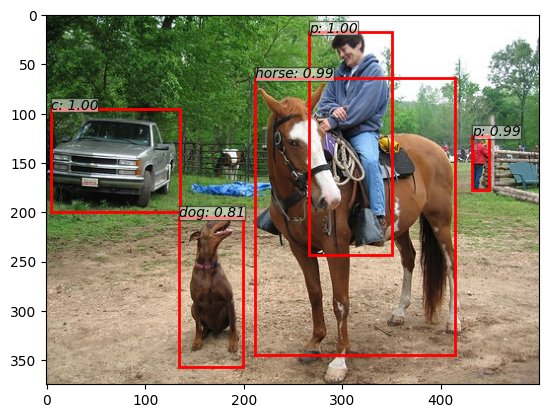

In [9]:
trainer.load('../fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth')
opt.caffe_pretrain=False # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img,visualize=True)
print(_labels)
print(_bboxes)
print(_scores)
# _probabilities = np.array(_probabilities)
print(_probabilities)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

In [6]:
detectiontxt = f'model_detections/labels/{image_name}.txt'

os.makedirs(os.path.dirname(detectiontxt), exist_ok=True)

with open(detectiontxt, 'a') as f:
    for i in range(len(_labels[0])):
        label = _labels[0][i]
        score = _scores[0][i]
        bbox = _bboxes[0][i]
        probability = _probabilities[0][i]
        line = (label, *bbox, *probability)
        print(line)
        # Write the line to the file
        f.write(("%g " *len(line)).rstrip() % line + "\n")
        

(6, 94.714874, 2.5186157, 193.54337, 138.25752, 0.014072583, 1.4492974e-05, 3.7068978e-05, 3.6809718e-06, 1.0912008e-05, 3.5005066e-06, 2.649385e-05, 3.06333e-05, 1.7329177e-06, 6.1499813e-06, 0.0007892028, 2.0992454e-06, 5.8858717e-05, 0.9843604, 0.00014539287, 0.00035891723, 1.1066177e-05, 2.890897e-05, 7.769458e-06, 2.9196004e-05, 9.321726e-07)
(12, 73.5952, 207.23288, 353.66205, 415.0887, 0.25106314, 0.00011218876, 0.00030711372, 0.00014078066, 0.00013005402, 0.00013643342, 0.000100080375, 0.00053277035, 2.658115e-05, 0.0002635075, 0.002911179, 2.458685e-05, 0.00019479064, 0.06836204, 0.0018276355, 0.67323697, 0.00017234846, 0.00020251526, 7.5024895e-05, 0.00014225348, 3.806986e-05)
(14, 21.700844, 268.66763, 238.67511, 342.34262, 0.027949383, 5.0175345e-06, 3.3460008e-05, 6.1513006e-06, 7.655578e-06, 3.8839707e-06, 8.884768e-06, 8.087506e-06, 1.6054556e-06, 1.4007835e-05, 0.000515671, 2.5567908e-06, 4.382735e-05, 0.9698435, 2.6077352e-05, 0.0014707019, 9.240918e-06, 3.3338558e-05,

In [7]:
detectiontxt = f'model_detections/labels/{image_name}.txt'
# load the detection results
detection = np.loadtxt(detectiontxt)

In [8]:
print(detection[1])

[1.20000e+01 7.35952e+01 2.07233e+02 3.53662e+02 4.15089e+02 2.51063e-01
 1.12189e-04 3.07114e-04 1.40781e-04 1.30054e-04 1.36433e-04 1.00080e-04
 5.32770e-04 2.65812e-05 2.63508e-04 2.91118e-03 2.45869e-05 1.94791e-04
 6.83620e-02 1.82764e-03 6.73237e-01 1.72348e-04 2.02515e-04 7.50249e-05
 1.42253e-04 3.80699e-05]


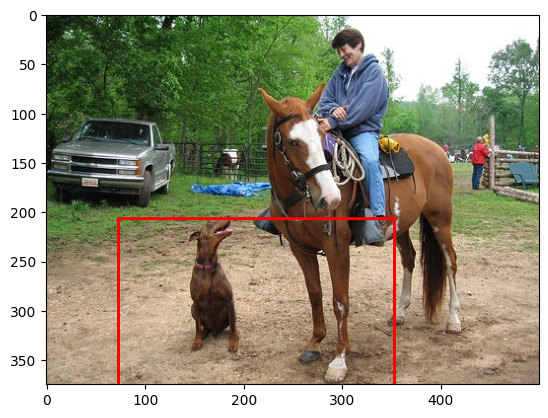

In [23]:
# # show me detection 2 on image
image = img.to('cpu').numpy()[0].transpose(1,2,0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()
# # plot the bounding box of horse on this, the coordinates are in format top left and then top right

bbox = detection[1][1:5]
bbox = bbox.astype(int)
label = int(detection[1][0])
label = labels_dict[str(label)]
image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
plt.imshow(image)
plt.show()




In [11]:
class_names = [labels_dict[str(int(det[0]))] for det in detection]
class_names

['car', 'horse', 'person', 'person']

In [12]:
print(detection[1])

[1.40000e+01 2.17008e+01 2.68668e+02 2.38675e+02 3.42343e+02 2.79494e-02
 5.01753e-06 3.34600e-05 6.15130e-06 7.65558e-06 3.88397e-06 8.88477e-06
 8.08751e-06 1.60546e-06 1.40078e-05 5.15671e-04 2.55679e-06 4.38273e-05
 9.69844e-01 2.60774e-05 1.47070e-03 9.24092e-06 3.33386e-05 4.84271e-06
 1.11108e-05 9.75097e-07]


In [13]:
our_detection = detection[1]

In [15]:
print(labels_dict[str(int(detection[1][0]))])

horse


In [17]:
overlayed_dir = 'overlayed/simple-faster-rcnn-pytorch/misc/demo'

for filename in os.listdir(overlayed_dir):
    img_path = os.path.join(overlayed_dir, filename)    
    img = cv2.imread(img_path)
    img = t.from_numpy(img)[None]
    img = img.permute(0,3,1,2)
    # print(img.shape)
    _bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img,visualize=True)
    
    filename = filename.split('.')[0]
    detectiontxt = f'detections/labels/{filename}.txt'
    os.makedirs(os.path.dirname(detectiontxt), exist_ok=True)

    with open(detectiontxt, 'a') as f:
        for i in range(len(_labels[0])):
            label = _labels[0][i]
            score = _scores[0][i]
            bbox = _bboxes[0][i]
            probability = _probabilities[0][i]
            line = (label, *bbox, *probability)
            f.write(("%g " *len(line)).rstrip() % line + "\n")


In [16]:
# Now lets load overlayed detections
detection_path = f'detections/labels/'
dets = os.listdir(detection_path)
# sort the detections
dets = sorted(dets, key=lambda x: x.split('.')[0])

masked_detections = {}
for det in dets:
    detections = np.loadtxt(os.path.join(detection_path, det))
    mask_det = []
    # detection is every new line in the txt file , each line contains 85 values , append them as a list to mask_det
    if type(detections[0]) == np.float64:
        detections = [detections]
    
    for detection in detections:
        mask_det.append(np.array(detection))
    if len(mask_det) == 85:
        # it is a single array , so make mask_det a 2d list
        mask_det = [mask_det]
    mask_name = det.split('.')[0][4:]
    # append mask_det as a list of detections to masked_detections
    # masked_detections.append(mask_det)
    # add with mask name 
    masked_detections[mask_name] = mask_det

In [17]:
masked_detections.keys()

dict_keys(['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '11

In [18]:
len(masked_detections)

5000

In [19]:
h = 375
w = 500

In [20]:
def compute_iou(box1 , box2):
    # first scale the values
    bbox1 = [0,0,0,0]
    bbox2 = [0,0,0,0]

    bbox1[0] = box1[1]*w
    bbox1[1] = box1[2]*h
    bbox1[2] = box1[3]*w
    bbox1[3] = box1[4]*h

    bbox2[0] = box2[1]*w
    bbox2[1] = box2[2]*h
    bbox2[2] = box2[3]*w
    bbox2[3] = box2[4]*h

    # the detections are in x,y,w,h format
    # convert to x1,y1,x2,y2


    bbox1 = [bbox1[0] - bbox1[2]/2 , bbox1[1] - bbox1[3]/2 , bbox1[0] + bbox1[2]/2 , bbox1[1] + bbox1[3]/2]
    bbox2 = [bbox2[0] - bbox2[2]/2 , bbox2[1] - bbox2[3]/2 , bbox2[0] + bbox2[2]/2 , bbox2[1] + bbox2[3]/2]

    bbox1 = np.asarray(bbox1)
    bbox2 = np.asarray(bbox2)

    # Now compute iou
    # x1 = max(bbox1[0], bbox2[0])
    # y1 = max(bbox1[1], bbox2[1])
    # x2 = min(bbox1[2], bbox2[2])
    # y2 = min(bbox1[3], bbox2[3])
    tl = np.vstack([bbox1[:2], bbox2[:2]]).max(axis=0)
    br = np.vstack([bbox1[2:], bbox2[2:]]).min(axis=0)


    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    # intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area1 = np.prod(bbox1[2:] - bbox1[:2])
    area2 = np.prod(bbox2[2:] - bbox2[:2])
    iou = intersection / float(area1 + area2 - intersection)

    return iou

In [21]:
iou = compute_iou(our_detection , masked_detections['0'][0])
iou

-0.0

In [22]:
def compute_class_similarity_score(box1 , box2):
    # create a numpy array with 85 zeros
    cbox1 = np.array(box1.copy()[5:])
    cbox2 = np.array(box2.copy()[5:])

    # compute cosine similarity
    dot_product = np.dot(cbox1, cbox2)
    norm_box1 = np.linalg.norm(cbox1)
    norm_box2 = np.linalg.norm(cbox2)
    return dot_product / (norm_box1 * norm_box2)

In [23]:
cs = compute_class_similarity_score(our_detection , masked_detections['0'][0])
cs

0.9965885376877915

In [24]:
def compute_detection_score(box1 , box2):
    iou = compute_iou(box1 , box2)
    cs = compute_class_similarity_score(box1 , box2)
    return iou*cs

In [25]:
sc = compute_detection_score(our_detection , masked_detections['0'][0])
sc

-0.0

In [26]:
print(our_detection)

[1.40000e+01 2.17008e+01 2.68668e+02 2.38675e+02 3.42343e+02 2.79494e-02
 5.01753e-06 3.34600e-05 6.15130e-06 7.65558e-06 3.88397e-06 8.88477e-06
 8.08751e-06 1.60546e-06 1.40078e-05 5.15671e-04 2.55679e-06 4.38273e-05
 9.69844e-01 2.60774e-05 1.47070e-03 9.24092e-06 3.33386e-05 4.84271e-06
 1.11108e-05 9.75097e-07]


In [27]:
# Now , for each mask , calculate the maximum similarity score with the original detection
similarity_scores = {}
for name in masked_detections.keys():
    mask_det = masked_detections[name]
    max_score = 0
    for det in mask_det:
        '''det may be an unsized object , so convert it to a list'''
        score = compute_detection_score(our_detection , det)
        if score > max_score:
            max_score = score
    similarity_scores[name] = max_score


In [28]:
# Now produce the final heatmap using the similarity scores and weighted masks
masks_dir = '../simple-faster-rcnn-pytorch\Masks2'
image_path = f'../simple-faster-rcnn-pytorch\misc\{image_name}.jpg'
image= cv2.imread(image_path)

weighted_mask = np.zeros((h,w))
# load the masks
masks = os.listdir(masks_dir)
# sort it
masks = sorted(masks, key=lambda x: x.split('.')[0])
for name in similarity_scores.keys():
    mask_path = os.path.join(masks_dir, 'mask' + name + '.png')
    mask = cv2.imread(mask_path)
    # mask is a 3 channel image, we only need one channel which is binary
    mask = mask[:,:,0]
    mask = mask/255
    weighted_mask += mask*similarity_scores[name]

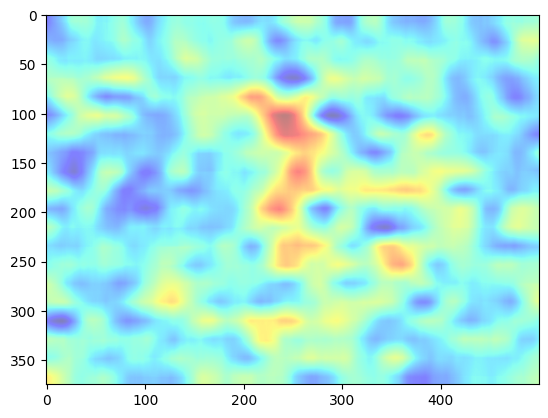

In [29]:
plt.imshow(weighted_mask , cmap='jet' , alpha=0.5)

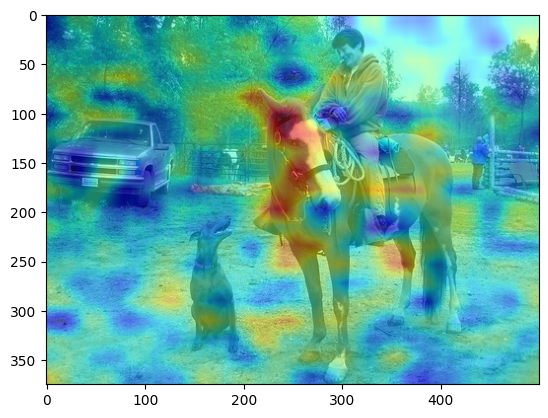

In [30]:
img = cv2.imread(f'../simple-faster-rcnn-pytorch\misc\{image_name}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# draw out detection on top of image

plt.imshow(img[:, :, ::-1])
plt.imshow(weighted_mask, cmap='jet', alpha=0.5)

In [31]:
#print the least value of weighted_mask
print(weighted_mask.min())
print(weighted_mask.max())

417.46681192865395
496.35079232546053


In [40]:
threshold = 465
weighted_mask[weighted_mask < threshold] = 0

41626


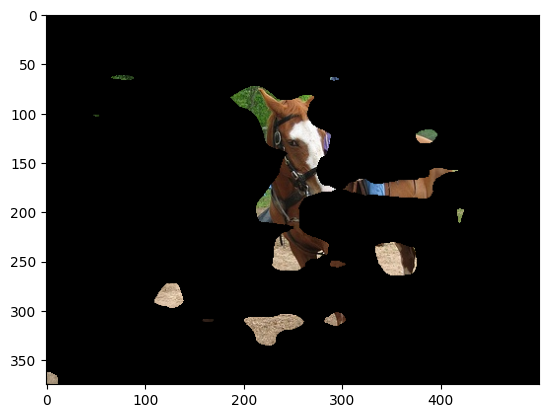

In [41]:
# Extract the region of interest from the image
roi = img.copy()
roi[weighted_mask == 0] = 0
plt.imshow(roi)

# Count number of pixels in roi image
num_pixels = np.sum(roi > 0)
print(num_pixels)

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [36]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(device)
dtype = torch.float32

cuda


In [37]:
from torchvision.models import vgg16
from utils import array_tool as at
from utils.config import opt

In [38]:
def decom_vgg16():
    # the 30th layer of features is relu of conv5_3
    if opt.caffe_pretrain:
        model = vgg16(pretrained=False)
        if not opt.load_path:
            model.load_state_dict(t.load(opt.caffe_pretrain_path))
    else:
        model = vgg16(not opt.load_path)

    features = list(model.features)[:30]
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6]
    if not opt.use_drop:
        del classifier[5]
        del classifier[2]
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False

    return nn.Sequential(*features), classifier

feat_ext, classifier = decom_vgg16()

In [39]:
def fgsm(model, x, y, e=0.1, target=None):
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)
    x.requires_grad = True
    scores = model(x)
    loss = F.cross_entropy(scores, y)
    model.zero_grad()
    loss.backward()
    x_grad = x.grad.data
    x_adv = x + e * x_grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def make_gt(out_boxes , class_label , img):
    num_boxes = out_boxes.shape[0]
    # gt should be of shape (num_boxes, 21)
    gt = np.zeros((num_boxes, 21))
    for i , box in enumerate(out_boxes):
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        # if more than 90% of pixeels in the bounding box are not black , then only do gt[i][class_label] = 1 , else gt[i][20] = 1
        # print(box , x1 , y1 , x2 , y2)
        # roi = img[x1:x2 , y1:y2]
        num_pixels = np.sum(roi > 0)
        if num_pixels > 0.9*(y2-y1)*(x2-x1):
            gt[i][class_label+1] = 1
        else:
            gt[i][0] = 1
    return torch.from_numpy(gt)

def pgd(model, x, y, loss_fn , e=0.1, alpha=0.01, iters=40 , num_classes = 21):
    # Convert x (image) to a PyTorch tensor
    # x = torch.from_numpy(x) # Add batch dimension (1, H, W, C) -> (1, C, H, W
    # Convert y (label) to a PyTorch tensor
    # make y a one-hot encoded vector of class labels with yth index as 1 , rest as 0 , total length is num_classes

    x = x.to(device=device, dtype=dtype)
    # y = y.to(device=device, dtype=torch.long)
    x_adv = x.clone().detach().requires_grad_(True).to(device=device, dtype=dtype)
    for i in range(iters):
        roi_cls_loc, roi_scores, rois, _ = model(x_adv)
        gt = make_gt(rois , y , x[0]).to(device=device, dtype=torch.float32)
    
        roi_scores = F.softmax(roi_scores, dim=1)
        loss = loss_fn(roi_scores, gt)
        model.zero_grad()
        loss.backward()
        x_adv.data = x_adv.data + alpha * x_adv.grad.sign()
        x_adv.data = torch.min(torch.max(x_adv.data, x - e), x + e)
        x_adv.data = torch.clamp(x_adv.data, 0, 1)

    return x_adv

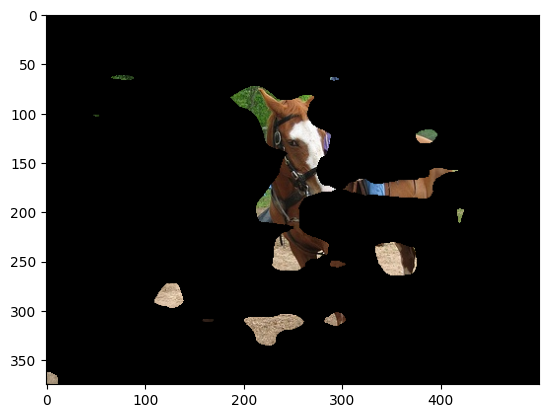

In [49]:
plt.imshow(roi)

In [41]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Setting up a new session...
Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
                  

Exception in user code:
------------------------------------------------------------


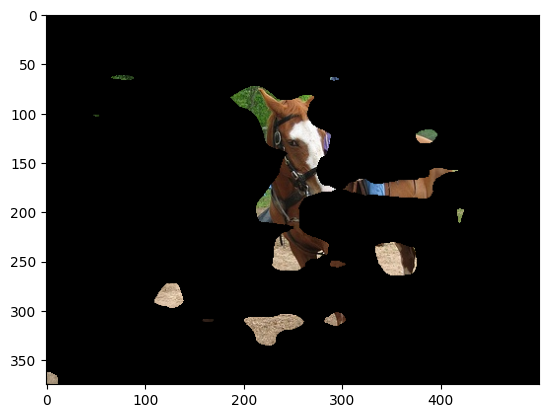

In [50]:
trainer.load('../fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth')
test_model = trainer.faster_rcnn
loss_fn = nn.CrossEntropyLoss()

u_pgd_roi = torch.tensor(roi.copy())
# divide values by 255
u_pgd_roi = u_pgd_roi/255
plt.imshow(u_pgd_roi)
u_pgd_roi = u_pgd_roi.permute(2,0,1)
u_pgd_roi = u_pgd_roi.unsqueeze(0)
u_pgd_roi = pgd(test_model, u_pgd_roi , 12 ,loss_fn , e=0.15, alpha=0.01, iters=40)
# x_adv = u_pgd_roi.clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
# x_adv = x_adv.unsqueeze(0)
# print(x_adv.shape)
# _ ,_ , _ , _ = test_model(x_adv)

torch.Size([1, 3, 375, 500])


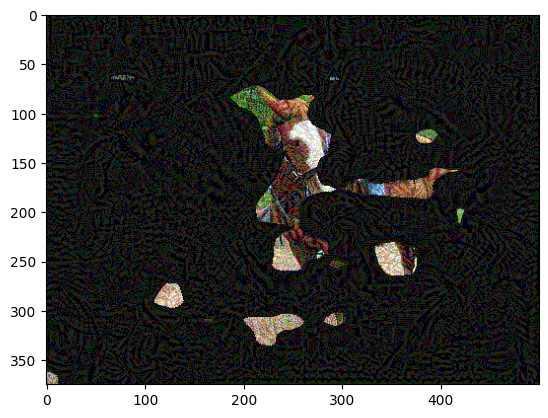

In [51]:
print(u_pgd_roi.shape)
perturbed_roi = u_pgd_roi.squeeze(0).permute(1,2,0).detach().cpu().numpy()
plt.imshow(perturbed_roi)

In [52]:
perturbed_img = u_pgd_roi.squeeze(0).permute(1,2,0).detach().cpu().numpy()
# replace black pixels with img pixels
perturbed_img = perturbed_img*255
perturbed_img = perturbed_img.astype(np.uint8)

h , w = roi.shape[:2]

for i in range(h):
    for j in range(w):
        if np.all(roi[i][j] == 0):
            perturbed_img[i][j] = img[i][j]


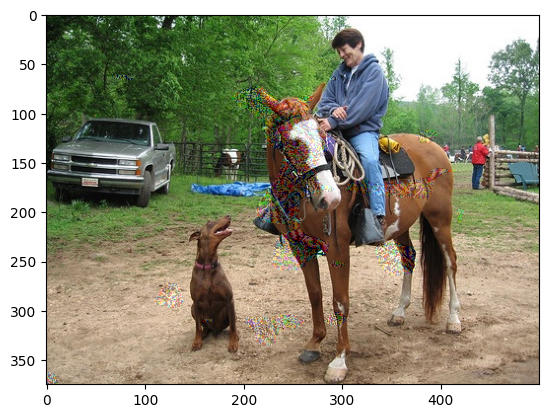

In [53]:
plt.imshow(perturbed_img)

In [54]:
# Save the perturbed image
p_img_name = 'perturbed_img2.jpg'
cv2.imwrite(p_img_name, cv2.cvtColor(perturbed_img, cv2.COLOR_RGB2BGR))

True

In [55]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Setting up a new session...
Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\krish\AppData\Local\Pr

Exception in user code:
------------------------------------------------------------


In [56]:
# Convert perturbed image to tensor
img2 = cv2.imread(p_img_name)
img2 = t.from_numpy(img2)[None]
img2 = img2.permute(0,3,1,2)
img2.shape


torch.Size([1, 3, 375, 500])

In [57]:
dir_overlayed_adv = 'overlayed_adv2'
def overlay_masks(masks_dir  , image_path):
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = os.listdir(masks_dir)
    image_name = image_path.split('/')[-1].split('.')[0]
    os.makedirs(f'{dir_overlayed_adv}/{image_name}', exist_ok=True)
    for mask_name in masks:
        mask_path = os.path.join(masks_dir, mask_name)
        mask = cv2.imread(mask_path)
        # mask is a 3 channel image, we only need one channel which is binary
        mask = mask[:,:,0]
        mask = mask/255

        # overlay mask on image
        overlay = image.copy()
        overlay[:,:,0] = mask*image[:,:,0]
        overlay[:,:,1] = mask*image[:,:,1]
        overlay[:,:,2] = mask*image[:,:,2]

        # save overlayed image
        cv2.imwrite(f'{dir_overlayed_adv}/{image_name}/{mask_name}', overlay)

In [ ]:
overlay_masks('../simple-faster-rcnn-pytorch\Masks2', p_img_name)

[array([ 6, 12, 14, 14])]
[array([[ 98.826904 ,   2.1775131, 188.6882   , 142.63925  ],
       [ 71.732285 , 189.5046   , 360.36536  , 405.14917  ],
       [ 11.094521 , 261.94888  , 256.24194  , 341.4326   ],
       [121.617676 , 430.30078  , 169.21484  , 451.60352  ]],
      dtype=float32)]
[array([0.9997814 , 0.98294234, 0.98952407, 0.9223257 ], dtype=float32)]
[array([[1.4466806e-01, 1.5856243e-04, 1.3115166e-03, 3.6554391e-04,
        4.1219086e-04, 2.8177010e-04, 4.0505169e-04, 1.4773234e-03,
        1.7275529e-04, 8.2260248e-04, 7.6897454e-04, 1.1242259e-04,
        2.2162365e-04, 5.9251781e-03, 1.1679943e-03, 8.3986753e-01,
        7.5158151e-04, 3.2173417e-04, 4.5947070e-04, 1.8772235e-04,
        1.4038103e-04],
       [5.1968493e-02, 9.3507821e-05, 5.0819933e-04, 4.2751064e-05,
        2.8207173e-04, 1.7226830e-05, 1.3246638e-04, 1.8576859e-04,
        2.4233655e-05, 1.5546597e-04, 6.2530185e-04, 8.1280217e-05,
        5.3153466e-04, 9.2767316e-01, 1.7894126e-04, 1.7118646e-

<Axes: >

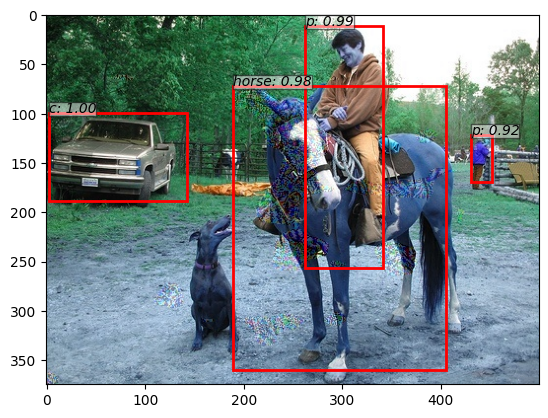

In [59]:
trainer.load('../fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth')
opt.caffe_pretrain=False # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img2,visualize=True)
print(_labels)
print(_bboxes)
print(_scores)
# _probabilities = np.array(_probabilities)
print(_probabilities)
vis_bbox(at.tonumpy(img2[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

In [60]:
m_det_dir = 'model_detections3'
detectiontxt2 = f'{m_det_dir}/labels/{image_name}.txt'

os.makedirs(os.path.dirname(detectiontxt2), exist_ok=True)

with open(detectiontxt2, 'a') as f:
    for i in range(len(_labels[0])):
        label = _labels[0][i]
        score = _scores[0][i]
        bbox = _bboxes[0][i]
        probability = _probabilities[0][i]
        line = (label, *bbox, *probability)
        print(line)
        # Write the line to the file
        f.write(("%g " *len(line)).rstrip() % line + "\n")
        

(6, 98.826904, 2.1775131, 188.6882, 142.63925, 0.14466806, 0.00015856243, 0.0013115166, 0.0003655439, 0.00041219086, 0.0002817701, 0.0004050517, 0.0014773234, 0.00017275529, 0.0008226025, 0.00076897454, 0.00011242259, 0.00022162365, 0.005925178, 0.0011679943, 0.83986753, 0.0007515815, 0.00032173417, 0.0004594707, 0.00018772235, 0.00014038103)
(12, 71.732285, 189.5046, 360.36536, 405.14917, 0.051968493, 9.350782e-05, 0.00050819933, 4.2751064e-05, 0.00028207173, 1.722683e-05, 0.00013246638, 0.00018576859, 2.4233655e-05, 0.00015546597, 0.00062530185, 8.128022e-05, 0.00053153466, 0.92767316, 0.00017894126, 0.017118646, 9.848667e-05, 0.000111154, 8.606469e-05, 6.8590976e-05, 1.663767e-05)
(14, 11.094521, 261.94888, 256.24194, 341.4326, 0.10016303, 2.6839696e-05, 0.00034305654, 0.00011894386, 0.00011583007, 0.00010957883, 3.640374e-05, 2.5197123e-05, 2.2980716e-05, 0.00039904687, 0.0009117095, 1.9913394e-05, 0.000622134, 0.86675155, 0.00010146735, 0.029771663, 0.00019701141, 0.00019152122, 2

In [61]:
detectiontxt2 = f'{m_det_dir}/labels/{image_name}.txt'
# load the detection results
detection2 = np.loadtxt(detectiontxt2)

In [62]:
class_names = [labels_dict[str(int(det[0]))] for det in detection2]
class_names

['car', 'horse', 'person', 'person']

In [64]:
print(labels_dict[str(int(detection2[2][0]))])

person


In [173]:
our_detection = detection2[2]

In [148]:
overlayed_dir = 'overlayed_adv/perturbed_img'

for filename in os.listdir(overlayed_dir):
    img_path = os.path.join(overlayed_dir, filename)    
    img = cv2.imread(img_path)
    img = t.from_numpy(img)[None]
    img = img.permute(0,3,1,2)
    # print(img.shape)
    _bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img,visualize=True)
    
    filename = filename.split('.')[0]
    detectiontxt2 = f'detections2/labels/{filename}.txt'
    os.makedirs(os.path.dirname(detectiontxt2), exist_ok=True)

    with open(detectiontxt2, 'a') as f:
        for i in range(len(_labels[0])):
            label = _labels[0][i]
            score = _scores[0][i]
            bbox = _bboxes[0][i]
            probability = _probabilities[0][i]
            line = (label, *bbox, *probability)
            f.write(("%g " *len(line)).rstrip() % line + "\n")


In [174]:
# Now lets load overlayed detections
detection_path = f'detections2/labels/'
dets = os.listdir(detection_path)
# sort the detections
dets = sorted(dets, key=lambda x: x.split('.')[0])
# print(dets)

masked_detections = {}
for det in dets:
    detections = np.loadtxt(os.path.join(detection_path, det))
    mask_det = []
    # detection is every new line in the txt file , each line contains 85 values , append them as a list to mask_det
    if(detections != []):
        if type(detections[0]) == np.float64:
            detections = [detections]
        
    for detection in detections:
        mask_det.append(np.array(detection))
    if len(mask_det) == 85:
        # it is a single array , so make mask_det a 2d list
        mask_det = [mask_det]
    mask_name = det.split('.')[0][4:]
    # append mask_det as a list of detections to masked_detections
    # masked_detections.append(mask_det)
    # add with mask name 
    masked_detections[mask_name] = mask_det

C:\Users\krish\AppData\Local\Temp\ipykernel_10112\19407044.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(detections != []):
C:\Users\krish\AppData\Local\Temp\ipykernel_10112\19407044.py:10: UserWarning: loadtxt: input contained no data: "detections2/labels/mask4796.txt"
  detections = np.loadtxt(os.path.join(detection_path, det))
C:\Users\krish\AppData\Local\Temp\ipykernel_10112\19407044.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(detections != []):
C:\Users\krish\AppData\Local\Temp\ipykernel_10112\19407044.py:10: UserWarning: loadtxt: input contained no data: "detections2/labels/mask972.txt"
  detections = np.loadtxt(os.path.join(detection_path, det))


In [175]:
masked_detections.keys()

dict_keys(['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '11

In [176]:
h = 375
w = 500

In [177]:
iou = compute_iou(our_detection , masked_detections['0'][0])
iou

-0.0

In [178]:
cs = compute_class_similarity_score(our_detection , masked_detections['0'][0])
cs

0.04784795892921376

In [179]:
sc = compute_detection_score(our_detection , masked_detections['0'][0])
sc

-0.0

In [180]:
# Now , for each mask , calculate the maximum similarity score with the original detection
similarity_scores = {}
for name in masked_detections.keys():
    mask_det = masked_detections[name]
    max_score = 0
    for det in mask_det:
        '''det may be an unsized object , so convert it to a list'''
        score = compute_detection_score(our_detection , det)
        if score > max_score:
            max_score = score
    similarity_scores[name] = max_score

In [181]:
# Now produce the final heatmap using the similarity scores and weighted masks
masks_dir = '../simple-faster-rcnn-pytorch\Masks2'
image_path = 'perturbed_img.jpg'
image= cv2.imread(image_path)

weighted_mask = np.zeros((h,w))
# load the masks
masks = os.listdir(masks_dir)
# sort it
masks = sorted(masks, key=lambda x: x.split('.')[0])
for name in similarity_scores.keys():
    mask_path = os.path.join(masks_dir, 'mask' + name + '.png')
    mask = cv2.imread(mask_path)
    # mask is a 3 channel image, we only need one channel which is binary
    mask = mask[:,:,0]
    mask = mask/255
    weighted_mask += mask*similarity_scores[name]

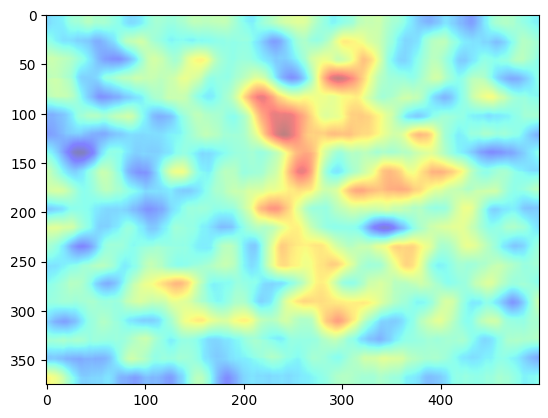

In [183]:
plt.imshow(weighted_mask , cmap='jet' , alpha=0.5)

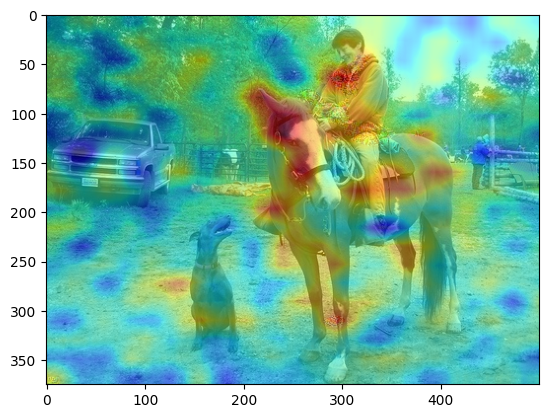

In [184]:
img = cv2.imread('perturbed_img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# draw out detection on top of image

plt.imshow(img[:, :, ::-1])
plt.imshow(weighted_mask, cmap='jet', alpha=0.5)